In [1]:
%cd /content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/offenseval2020-turkish

/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/offenseval2020-turkish


# **Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import seaborn as sns

/home/healthai-tm214/vitacognita/yolovenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data Visualization**

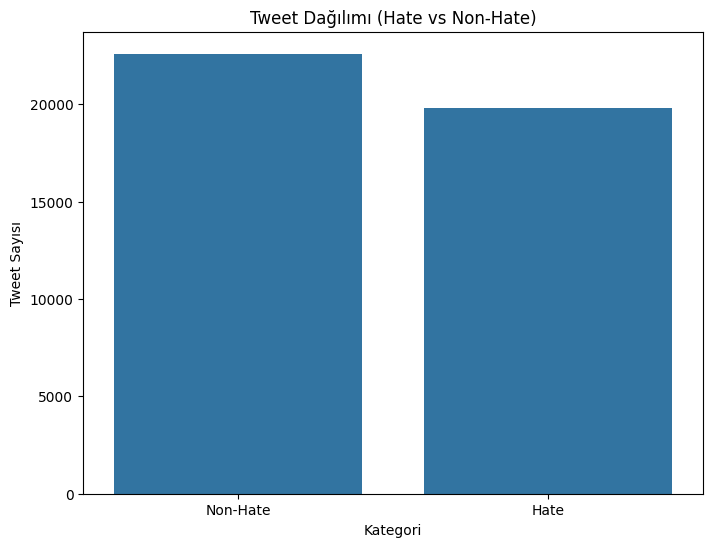

In [3]:
# Verileri yükle
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')
# Nefret içeren ve içermeyen tweet'lerin sayısını görselleştir
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=train_data)
ax.set_title('Tweet Dağılımı (Hate vs Non-Hate)')
ax.set_xlabel('Kategori')
ax.set_ylabel('Tweet Sayısı')
plt.xticks([0, 1], ['Non-Hate', 'Hate'])  # Etiket isimlerini belirtiniz
plt.show()

[nltk_data] Downloading package stopwords to /home/healthai-
[nltk_data]     tm214/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


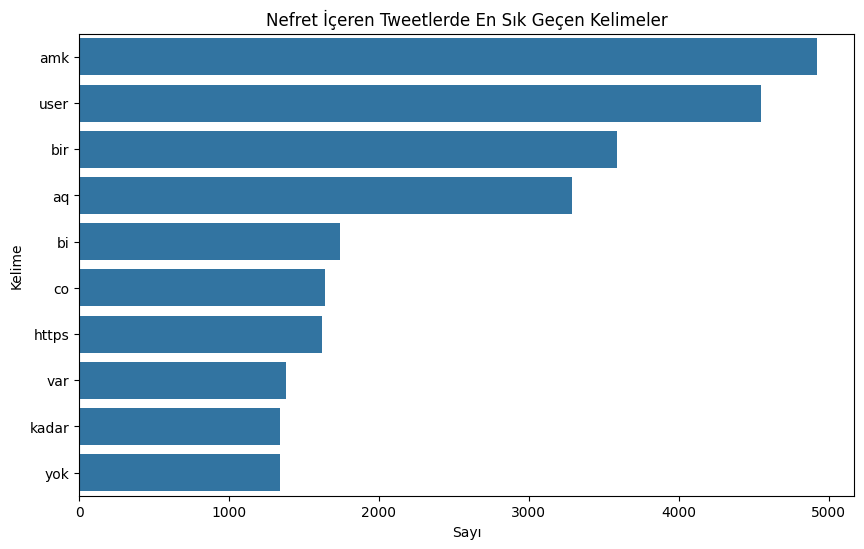

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
# nltk kütüphanesinden Türkçe stop words yükleyelim
import nltk

def frekans():
    nltk.download('stopwords')
    turkish_stopwords = stopwords.words('turkish')

    # Nefret içeren tweet'leri filtrele
    nefret_tweets = train_data[train_data['label'] == 1]['text']

    # En sık geçen kelimeleri say (Türkçe stop words ile)
    vectorizer = CountVectorizer(stop_words=turkish_stopwords, max_features=10)
    nefret_counts = vectorizer.fit_transform(nefret_tweets)
    sum_words = nefret_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Kelime frekanslarını çubuk grafikte göster
    words_df = pd.DataFrame(words_freq, columns=['word', 'count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=words_df)
    plt.title('Nefret İçeren Tweetlerde En Sık Geçen Kelimeler')
    plt.xlabel('Sayı')
    plt.ylabel('Kelime')
    plt.show()

frekans()

# **Normalization Step**

In [5]:
import re

def normalize_text(text):
    #Kullanıcı adlarını kaldırır
    #text = re.sub(r'([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)','', text)

    text = re.sub(r'@\w+', '', text)
    # Tüm harfleri küçük harfe çevir (uncased model kullanılıyorsa)
    text = text.lower()

    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # HTML etiketlerini kaldır
    text = re.sub(r'<.*?>', '', text)

    # Noktalama işaretleri dışındaki özel karakterleri kaldır
    text = re.sub(r'[^a-zA-Z0-9ığüşöçİĞÜŞÖÇ\s]', '', text)

    # Ekstra boşlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()


    #Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern.sub(r' ', text)

    return text

[nltk_data] Downloading package stopwords to /home/healthai-
[nltk_data]     tm214/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


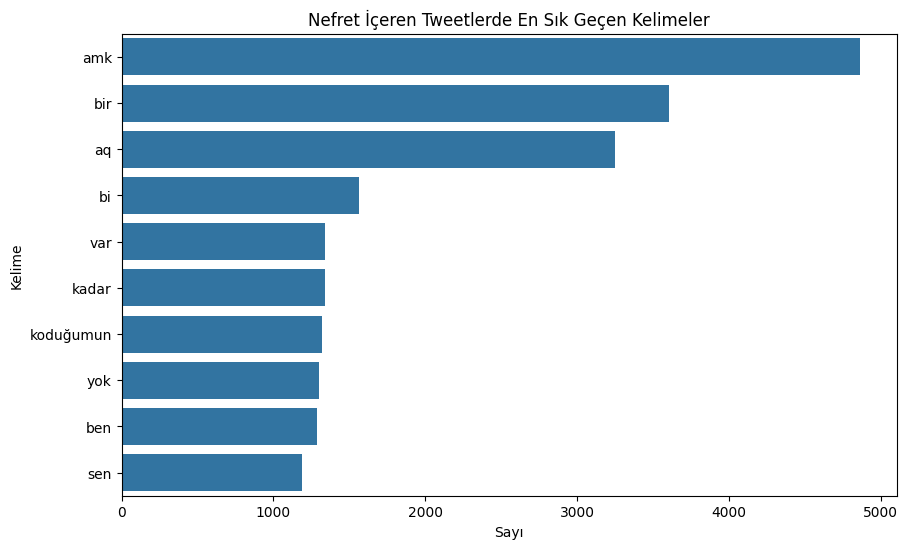

In [7]:
#Verileri normalize edin
train_data['text'] = train_data['text'].apply(normalize_text)
val_data['text'] = val_data['text'].apply(normalize_text)

frekans()

# **Split data into train, val and test set**

In [ ]:
# Veriyi eğitim, doğrulama ve test setlerine bölün
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# **Convert data into datasets format**

In [ ]:
!pip install datasets==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, DatasetDict
# Veriyi datasets formatına dönüştürün
def df_to_dataset(df):
    return {'text': df['text'].tolist(), 'label': df['label'].tolist()}

train_dataset = load_dataset('pandas', data_files={'train': df_to_dataset(train_data)})
val_dataset = load_dataset('pandas', data_files={'validation': df_to_dataset(val_data)})
test_dataset = load_dataset('pandas', data_files={'test': df_to_dataset(test_data)})

AttributeError: 'dict' object has no attribute 'decode'

# **Split datasets in text and labels**

In [8]:
X_train=train_data['text']
y_train=train_data['label']
X_val=val_data['text']
y_val=val_data['label']
X_test = test_data['text']
y_test = test_data['label']

# **Load model and tokenizer**

In [7]:
# Model ve tokenizer'ı yükleyin
model_name = "dbmdz/bert-base-turkish-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenizasyon ve veri kümesini işleyin
def tokenize_function(tweets):
    return tokenizer(tweets, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Set training parameters and start training**

In [15]:
# PyTorch veri setlerini hazırla
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Define the compute_metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


train_dataset = TweetDataset(train_encodings, y_train.tolist())
val_dataset = TweetDataset(val_encodings, y_val.tolist())
# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
# Eğitim argümanlarını ayarla
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Trainer'ı kur ve eğitimi başlat
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


cuda


/home/healthai-tm214/vitacognita/yolovenv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 24/13250 [01:12<11:04:19,  3.01s/it]
                                                    
  6%|▋         | 500/7950 [05:13<1:18:27,  1.58it/s]

{'loss': 0.0976, 'grad_norm': 3.7780027389526367, 'learning_rate': 5e-05, 'epoch': 0.19}


                                                     
 13%|█▎        | 1000/7950 [10:24<1:12:42,  1.59it/s]

{'loss': 0.0691, 'grad_norm': 0.0830019861459732, 'learning_rate': 4.664429530201342e-05, 'epoch': 0.38}


                                                     
 19%|█▉        | 1500/7950 [15:39<1:09:38,  1.54it/s]

{'loss': 0.0581, 'grad_norm': 0.10138286650180817, 'learning_rate': 4.328859060402685e-05, 'epoch': 0.57}


                                                     
 25%|██▌       | 2000/7950 [20:53<1:01:43,  1.61it/s]

{'loss': 0.0657, 'grad_norm': 0.04171767830848694, 'learning_rate': 3.993288590604027e-05, 'epoch': 0.75}


                                                     
 31%|███▏      | 2500/7950 [26:08<57:16,  1.59it/s] 

{'loss': 0.0756, 'grad_norm': 0.022712690755724907, 'learning_rate': 3.6577181208053695e-05, 'epoch': 0.94}


 33%|███▎      | 2650/7950 [27:39<49:54,  1.77it/s]












































































































                                                   
                                                 

 33%|███▎      | 2650/7950 [27:57<49:54,  1.77it/s]



{'eval_loss': 0.6718665361404419, 'eval_accuracy': 0.8690205011389521, 'eval_f1': 0.8713376146863028, 'eval_precision': 0.874556124212104, 'eval_recall': 0.8690205011389521, 'eval_runtime': 18.5203, 'eval_samples_per_second': 94.815, 'eval_steps_per_second': 5.939, 'epoch': 1.0}


                                                      
 38%|███▊      | 3000/7950 [31:34<51:28,  1.60it/s] 

{'loss': 0.1061, 'grad_norm': 0.22263361513614655, 'learning_rate': 3.3221476510067115e-05, 'epoch': 1.13}


                                                   
 44%|████▍     | 3500/7950 [36:49<46:13,  1.60it/s] 

{'loss': 0.1086, 'grad_norm': 0.09121616184711456, 'learning_rate': 2.986577181208054e-05, 'epoch': 1.32}


                                                   
 50%|█████     | 4000/7950 [42:04<41:53,  1.57it/s] 

{'loss': 0.1048, 'grad_norm': 6.3969573974609375, 'learning_rate': 2.651006711409396e-05, 'epoch': 1.51}


                                                   
 57%|█████▋    | 4500/7950 [47:09<33:56,  1.69it/s] 

{'loss': 0.1152, 'grad_norm': 5.818449020385742, 'learning_rate': 2.3154362416107384e-05, 'epoch': 1.7}


                                                   
 63%|██████▎   | 5000/7950 [52:04<30:39,  1.60it/s] 

{'loss': 0.0995, 'grad_norm': 0.03202877938747406, 'learning_rate': 1.9798657718120804e-05, 'epoch': 1.89}


 67%|██████▋   | 5300/7950 [55:12<26:47,  1.65it/s]












































































































                                                   
                                                 

 67%|██████▋   | 5300/7950 [55:31<26:47,  1.65it/s]



{'eval_loss': 0.4223237931728363, 'eval_accuracy': 0.8826879271070615, 'eval_f1': 0.8820560263716842, 'eval_precision': 0.8815011590614716, 'eval_recall': 0.8826879271070615, 'eval_runtime': 19.6531, 'eval_samples_per_second': 89.35, 'eval_steps_per_second': 5.597, 'epoch': 2.0}


                                                     
 69%|██████▉   | 5500/7950 [57:45<24:02,  1.70it/s] 

{'loss': 0.0843, 'grad_norm': 0.03713482245802879, 'learning_rate': 1.644295302013423e-05, 'epoch': 2.08}


                                                     
 75%|███████▌  | 6000/7950 [1:02:38<18:57,  1.71it/s]

{'loss': 0.0519, 'grad_norm': 0.05381620675325394, 'learning_rate': 1.3087248322147652e-05, 'epoch': 2.26}


                                                     
 82%|████████▏ | 6500/7950 [1:07:49<15:29,  1.56it/s] 

{'loss': 0.0377, 'grad_norm': 4.957452774047852, 'learning_rate': 9.731543624161075e-06, 'epoch': 2.45}


                                                     
 88%|████████▊ | 7000/7950 [1:12:50<09:17,  1.70it/s] 

{'loss': 0.0392, 'grad_norm': 0.056575458496809006, 'learning_rate': 6.375838926174497e-06, 'epoch': 2.64}


                                                     
 94%|█████████▍| 7500/7950 [1:17:47<04:41,  1.60it/s] 

{'loss': 0.0408, 'grad_norm': 0.02506452426314354, 'learning_rate': 3.02013422818792e-06, 'epoch': 2.83}


100%|██████████| 7950/7950 [1:22:29<00:00,  1.67it/s]












































































































                                                     
                                                   

100%|██████████| 7950/7950 [1:22:49<00:00,  1.67it/s]



{'eval_loss': 0.6294947862625122, 'eval_accuracy': 0.8878132118451025, 'eval_f1': 0.8840193631902832, 'eval_precision': 0.8829881971024608, 'eval_recall': 0.8878132118451025, 'eval_runtime': 19.7426, 'eval_samples_per_second': 88.945, 'eval_steps_per_second': 5.572, 'epoch': 3.0}


                                                     
100%|██████████| 7950/7950 [1:22:58<00:00,  1.60it/s] 

{'train_runtime': 4978.8224, 'train_samples_per_second': 25.547, 'train_steps_per_second': 1.597, 'train_loss': 0.07491818266094856, 'epoch': 3.0}


TrainOutput(global_step=7950, training_loss=0.07491818266094856, metrics={'train_runtime': 4978.8224, 'train_samples_per_second': 25.547, 'train_steps_per_second': 1.597, 'total_flos': 3.346614757545984e+16, 'train_loss': 0.07491818266094856, 'epoch': 3.0})

# **Test model**

In [16]:
# Modeli değerlendirin
test_dataset = TweetDataset(test_encodings, y_test.tolist())
metrics = trainer.evaluate(eval_dataset=test_dataset)
print(metrics)


100%|██████████| 554/554 [01:38<00:00,  5.63it/s]

{'eval_loss': 0.27731844782829285, 'eval_accuracy': 0.9229465597107671, 'eval_f1': 0.9229428258071829, 'eval_precision': 0.9230028167057139, 'eval_recall': 0.9229465597107671, 'eval_runtime': 98.6519, 'eval_samples_per_second': 89.72, 'eval_steps_per_second': 5.616, 'epoch': 3.0}


In [17]:
metrics

{'eval_loss': 0.27731844782829285,
 'eval_accuracy': 0.9229465597107671,
 'eval_f1': 0.9229428258071829,
 'eval_precision': 0.9230028167057139,
 'eval_recall': 0.9229465597107671,
 'eval_runtime': 98.6519,
 'eval_samples_per_second': 89.72,
 'eval_steps_per_second': 5.616,
 'epoch': 3.0}

# **Training with classic ML methods**

In [16]:
# Veri vektörizasyonu
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Naive Bayes modeli
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)

# Logistic Regression modeli
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
lr_predictions = lr_model.predict(X_test_vec)

# Performans metriklerini yazdır
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4436
           1       0.93      0.86      0.89      4415

    accuracy                           0.90      8851
   macro avg       0.90      0.90      0.90      8851
weighted avg       0.90      0.90      0.90      8851

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4436
           1       0.97      0.84      0.90      4415

    accuracy                           0.90      8851
   macro avg       0.91      0.90      0.90      8851
weighted avg       0.91      0.90      0.90      8851



Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4436
           1       0.89      0.90      0.89      4415

    accuracy                           0.89      8851
   macro avg       0.89      0.89      0.89      8851
weighted avg       0.89      0.89      0.89      8851

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4436
           1       0.96      0.84      0.89      4415

    accuracy                           0.90      8851
   macro avg       0.91      0.90      0.90      8851
weighted avg       0.91      0.90      0.90      8851



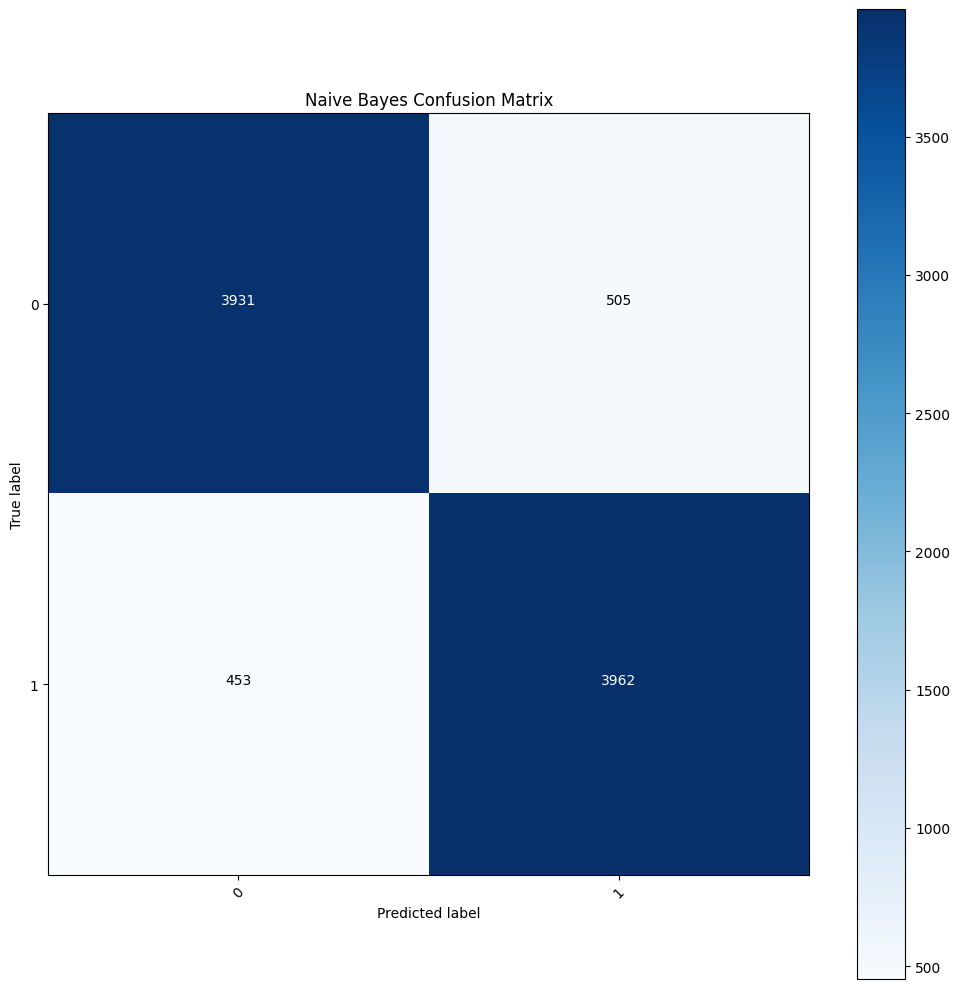

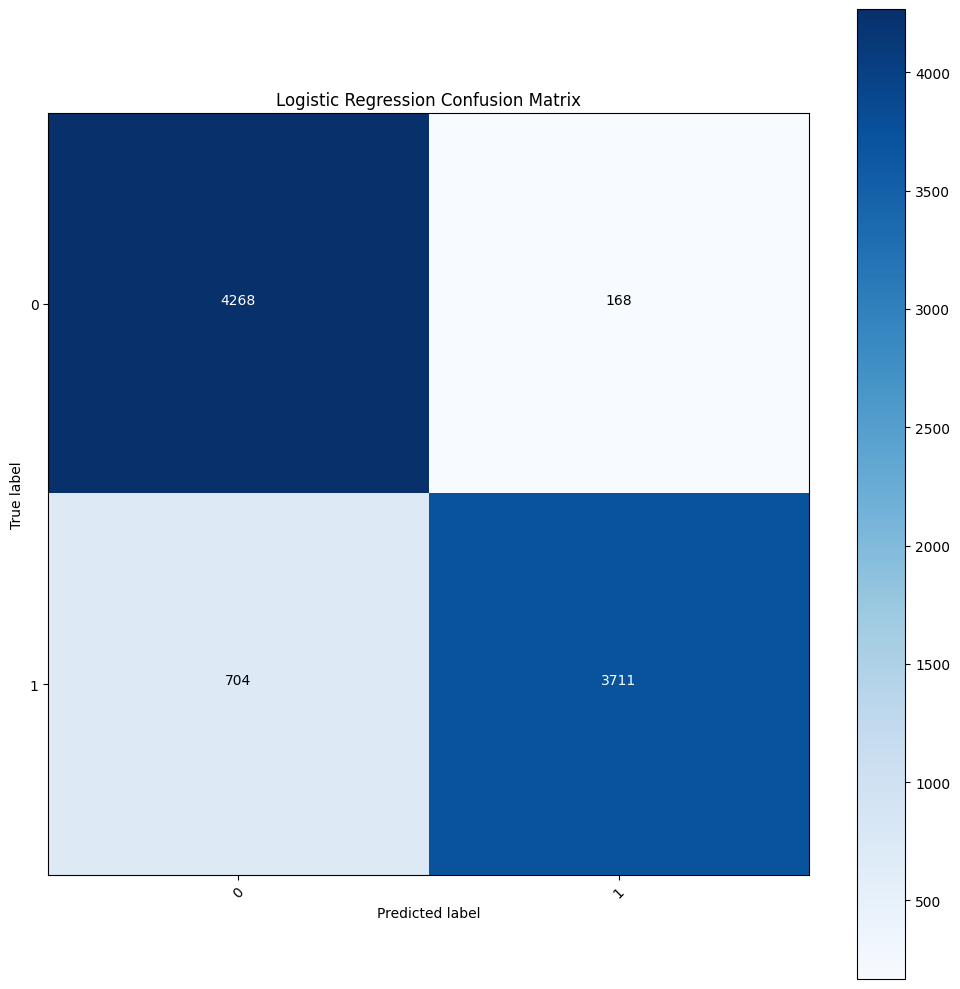

In [15]:
#when test is normalized
test_data_normalized = pd.read_csv('test.csv')
test_data_normalized['text']= test_data_normalized['text'].apply(normalize_text)
X_test_normalized= test_data_normalized['text']
y_test_normalized= test_data_normalized['label']

X_test_vec_normalized = vectorizer.transform(X_test_normalized)

# Naive Bayes modeli

nb_predictions = nb_model.predict(X_test_vec_normalized)

# Logistic Regression modeli

lr_predictions = lr_model.predict(X_test_vec_normalized)

# Performans metriklerini yazdır
print("Naive Bayes Classification Report:")
print(classification_report(y_test_normalized, nb_predictions))

print("Logistic Regression Classification Report:")
print(classification_report(y_test_normalized, lr_predictions))


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations inside the matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Naive Bayes için confusion matrix
nb_cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(10,10))
plot_confusion_matrix(nb_cm, classes=np.unique(y_test), title='Naive Bayes Confusion Matrix')
plt.show()

# Logistic Regression için confusion matrix
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(10,10))
plot_confusion_matrix(lr_cm, classes=np.unique(y_test), title='Logistic Regression Confusion Matrix')
plt.show()


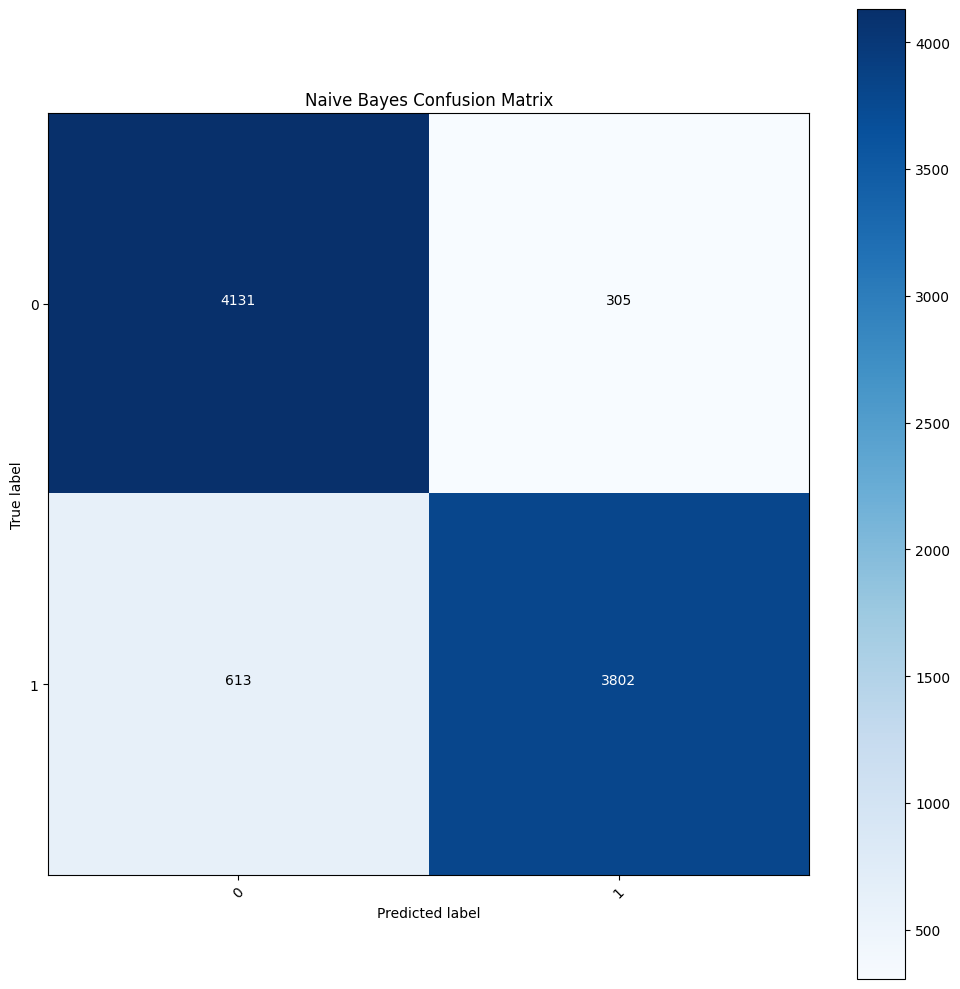

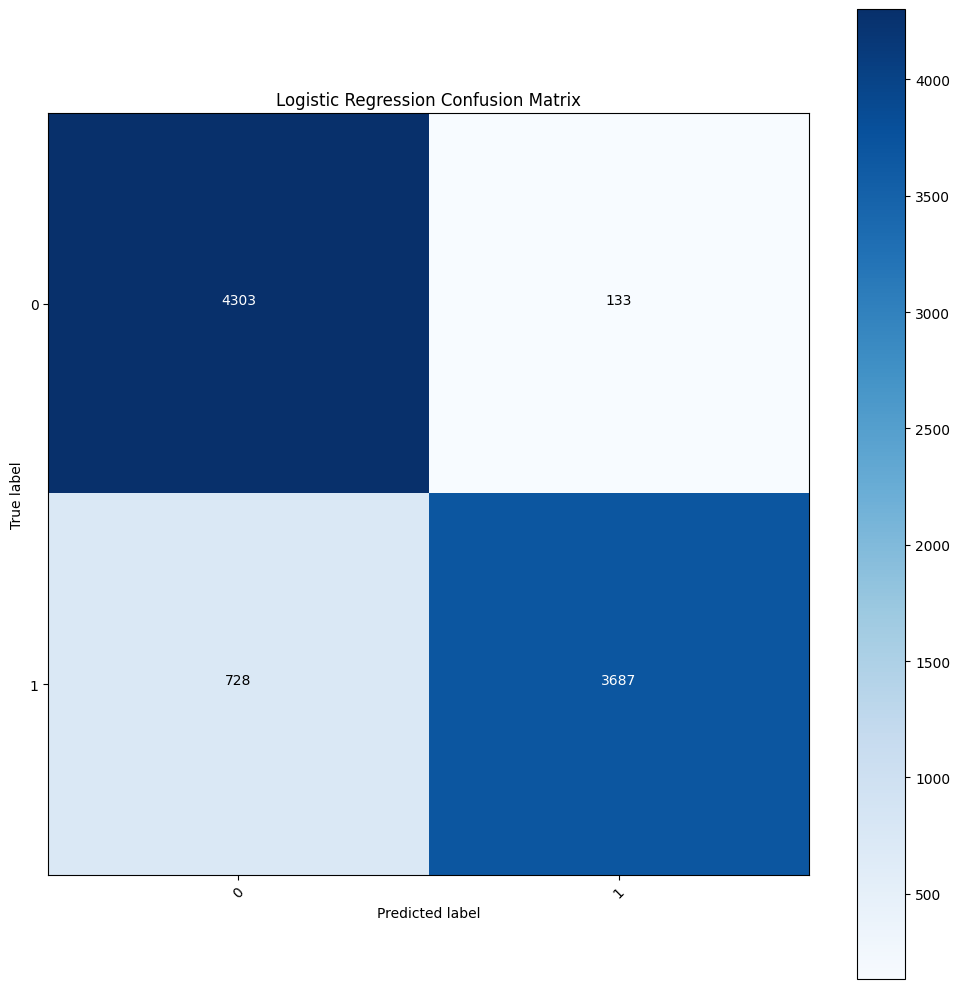

In [17]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations inside the matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Naive Bayes için confusion matrix
nb_cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(10,10))
plot_confusion_matrix(nb_cm, classes=np.unique(y_test), title='Naive Bayes Confusion Matrix')
plt.show()

# Logistic Regression için confusion matrix
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(10,10))
plot_confusion_matrix(lr_cm, classes=np.unique(y_test), title='Logistic Regression Confusion Matrix')
plt.show()
